In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import re
import sklearn
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import time
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier ,AdaBoostClassifier, 
                             GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.cross_validation import KFold


In [2]:
train = pd.read_csv(r"C:\Users\admin\Downloads\titanic\train.csv")
test = pd.read_csv(r"C:\Users\admin\Downloads\titanic\test.csv")
PassengerId = test['PassengerId']

In [3]:
test.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
all_data = [train, test]

In [5]:
for data_set in all_data:
    data_set["Name_length"] = data_set["Name"].apply(len)
    data_set["Has_Cabin"] = data_set["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    data_set["FamilySize"] = data_set["SibSp"] + data_set["Parch"] + 1
    data_set["IsAlone"] = 0
    data_set.loc[data_set["FamilySize"] == 1, "IsAlone"] = 1
    data_set["Embarked"] = data_set["Embarked"].fillna("S")
    data_set["Fare"] = data_set["Fare"].fillna(train["Fare"].median())
# train["CategoricalFare"] = pd.qcut(train["Fare"], 4)


# Pandas Tips

1. pandas可以用apply(),类似于scala中的map()函数： 
                                               data["slice"].apply(lambda x: x+1);
2. pandas可以用map(),用于映射转换：
                                               data["slcie"].map({"a":"b"});
3. pandas中的qcut()可以用于快速进行类别标签：
                                               pd.qcut([1,2,3,4], 4);

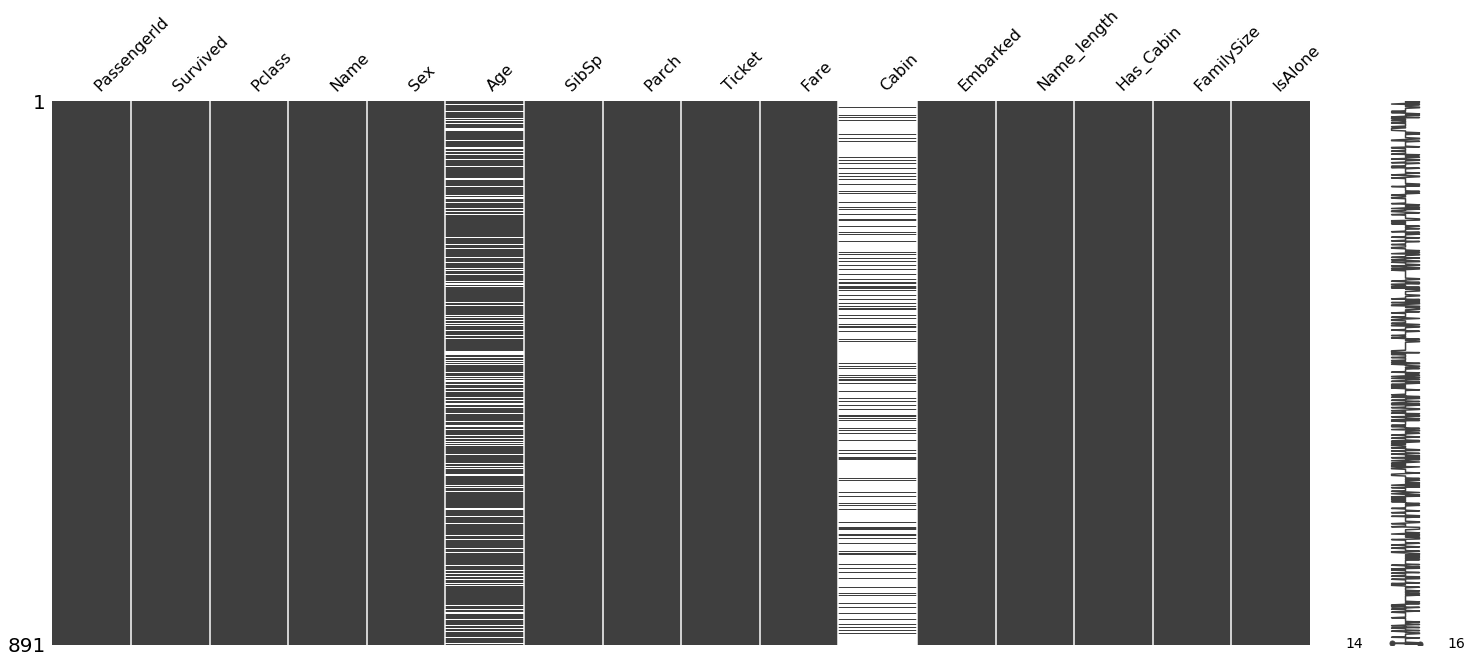

In [6]:
msno.matrix(train)

In [7]:
for data_set in all_data:
    age_avg = data_set["Age"].mean()
    age_std = data_set["Age"].std()
    age_null_count = data_set["Age"].isnull().sum()
    age_null_random = np.random.randint(age_avg-age_std, age_avg+age_std, size=age_null_count)
    data_set["Age"][np.isnan(data_set["Age"])] = age_null_random
# data_set["Age_class"] = pd.cut(data_set["Age"], 5)

In [8]:
def get_title(name):
    sech = re.search(r"([A-Za-z]+)\.", name)
    if sech:
        return sech.group(1)
    return ""

for data_set in all_data:
    data_set["Title"] = data_set["Name"].apply(get_title)
    data_set["Title"] = data_set["Title"].replace(["Lady", "Countess", "Capy","Col","Don","Dr","Major","Rev",'Sir', 'Jonkheer', 'Dona'],"Rare")
    data_set['Title'] = data_set["Title"].replace("Ms", "Miss")
    data_set['Title'] = data_set["Title"].replace("Mme", "Mrs")
    data_set["Sex"] = data_set["Sex"].map({"female":0, "male":1}).astype(int)
    title_dcit = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    data_set["Title"] = data_set["Title"].map(title_dcit)
    data_set["Title"] = data_set["Title"].fillna(0)
    data_set['Embarked'] = data_set['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
    data_set.loc[ data_set['Fare'] <= 7.91, 'Fare'] = 0
    data_set.loc[(data_set['Fare'] > 7.91) & (data_set['Fare'] <= 14.454), 'Fare'] = 1
    data_set.loc[(data_set['Fare'] > 14.454) & (data_set['Fare'] <= 31), 'Fare'] = 2
    data_set.loc[ data_set['Fare'] > 31, 'Fare'] = 3 
    data_set.loc[ data_set['Age'] > 64, 'Age'] = 4 

In [9]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', "IsAlone", "Sex", "Age", "FamilySize"]
train = train.drop(drop_elements, axis = 1)
# train = train.drop(["CategoricalFare", "Age_class"], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [10]:
train.describe()

,Survived,Pclass,Parch,Fare,Embarked,Name_length,Has_Cabin,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.381594,1.505051,0.361392,26.965208,0.228956,1.718294
std,0.486592,0.836071,0.806057,1.118148,0.635673,9.281607,0.420397,1.028958
min,0.000000,1.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.500000,0.000000,20.000000,0.000000,1.000000
50%,0.000000,3.000000,0.000000,2.000000,0.000000,25.000000,0.000000,1.000000
75%,1.000000,3.000000,0.000000,2.000000,1.000000,30.000000,0.000000,2.000000
max,1.000000,3.000000,6.000000,3.000000,2.000000,82.000000,1.000000,5.000000


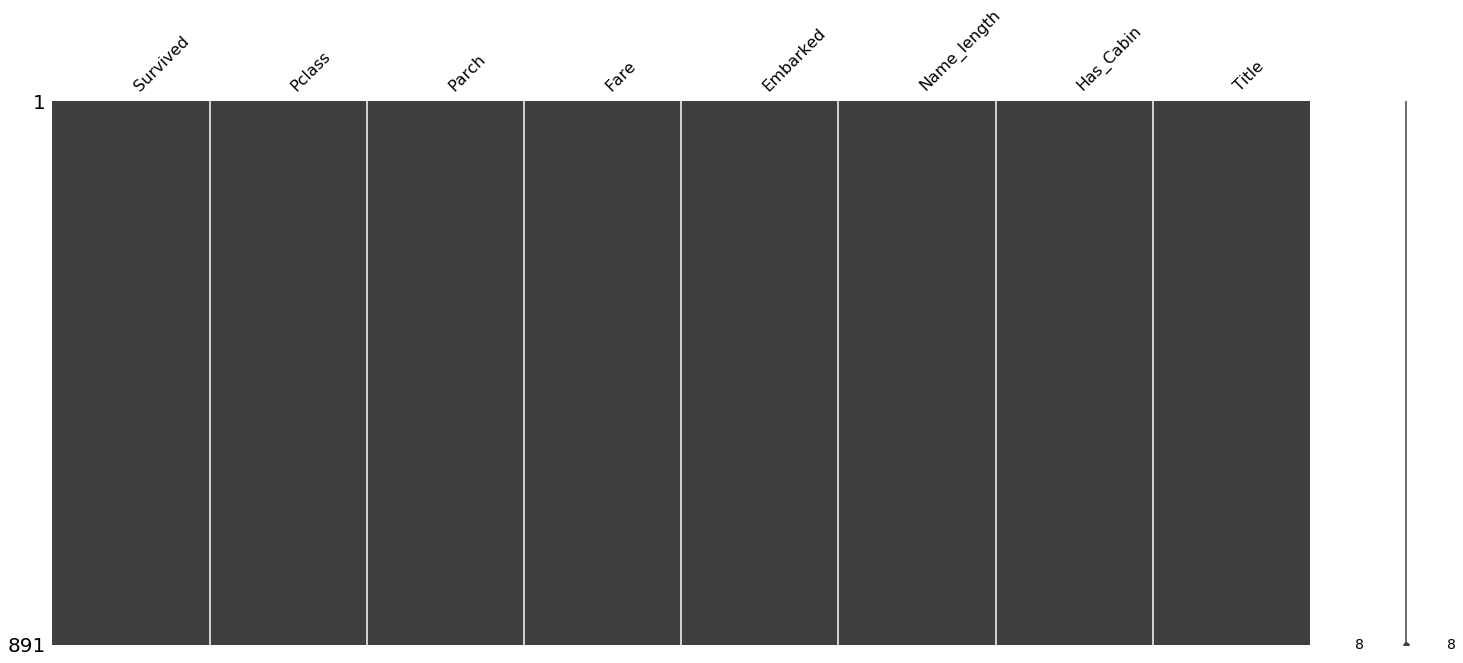

In [11]:
msno.matrix(train)

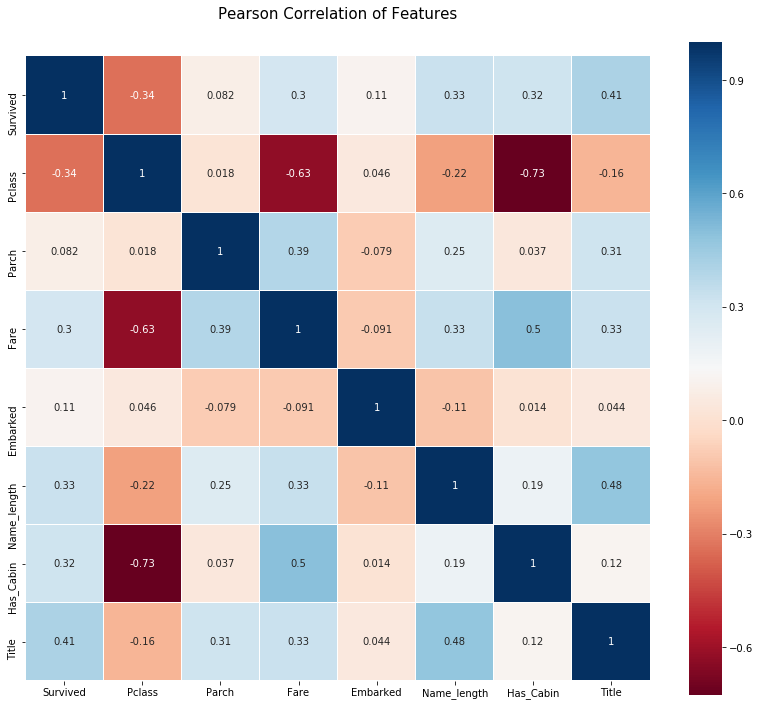

In [12]:
# 就是线条颜色
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [13]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params["random_state"]=seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def predict_proba(self, x):
        return self.clf.predict_proba(x)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)


def get_oof(clf, x_train, y_train, x_test):
    of_train = np.zeros((ntrain,))
    of_test = np.zeros((ntest,))
    of_test_kf = np.empty((NFOLDS, ntest))
    
    for i, (tr_index, te_index) in enumerate(kf):
        x_trian_tr = x_train[tr_index]
        y_train_tr = y_train[tr_index]
        x_train_te = x_train[te_index]
        
        clf.train(x_trian_tr, y_train_tr)
        
        of_train[te_index] = clf.predict(x_train_te)
        of_test_kf[i, :] = clf.predict(x_test)
        
    of_test[:] = of_test_kf.mean(axis=0)
    
    return of_train.reshape(-1, 1), of_test.reshape(-1, 1) 
        

In [14]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025,
    "probability":True
    }

In [15]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [16]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [17]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

gbm = xgb.XGBClassifier(
learning_rate = 0.02,
 n_estimators= 3000,
 max_depth= 6,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.5,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)

print("Training is complete")

Training is complete


In [26]:
alg_list = [gbm, rf ,et, ada, gb, svc]
alg_name = ["gbm", "rf", "et", "ada", "gb", "svc"]
alg_dict = {"{}".format(alg_name):alg  for alg_name, alg in zip(alg_name, alg_list)}


def model_predict(alg, x_train, y_train):
    train_predictions = alg.predict(x_train)
    train_predprob = alg.predict_proba(x_train)
    roc_auc = metrics.roc_auc_score(y_train, train_predprob[:, 1])
    acc = metrics.accuracy_score(train_predictions, y_train)
    fpr, tpr, thresh = metrics.roc_curve(y_train, train_predprob[:, 1])
    
    return (fpr, tpr), acc, roc_auc

x_train = x_train[:500]
y_train = y_train[:500]

def plot_all(plot_dict, x_train, y_train):
    for alg_name, alg in plot_dict.items():
        start_time = time.time()
        ft, acc, roc = model_predict(alg, x_train, y_train)
        end_time = time.time()
        during = end_time - start_time
        plt.plot(ft[0], ft[1], label="clf:%s_AUC:%.2f_time:%.2f"%(alg_name, roc, during))
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend(loc="lower right")
    plt.show()

i=3
plot_all(alg_dict, x_train[:i*100], y_train[:i*100])

gbm:0.04589486122131348
rf:0.3080558776855469
et:0.2066326141357422
ada:0.10196638107299805
gb:0.01073455810546875
svc:0.004988670349121094
